In [14]:
!pip install transformers==3.4.0

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [15]:
import pandas as pd
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.models import Model
from keras.layers.core import Dense, Dropout
import transformers
from transformers import TFBertModel,  BertConfig, BertTokenizerFast, RobertaTokenizer, RobertaModel, TFXLMRobertaModel
from transformers import AutoTokenizer,TFXLMRobertaModel, XLMRobertaModel,XLMTokenizer,XLMWithLMHeadModel
from transformers import XLMForSequenceClassification, XLMTokenizer, XLMConfig
import matplotlib.pyplot as plt
import numpy as np

In [16]:
transformers.__version__

'3.4.0'

In [17]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

Running on TPU  grpc://10.0.0.2:8470


In [18]:
train = pd.read_csv('../input/modified/train_modified.csv')
valid = pd.read_csv('../input/modified/val_modified.csv')
test = pd.read_csv('../input/modified/test_modified.csv')

In [19]:
xtrain, ytrain = train.Comment.values, train.Emotion.values
xvalid, yvalid = valid.Comment.values, valid.Emotion.values
xtest, ytest = test.Comment.values, test.Emotion.values

In [20]:
tokenizer = AutoTokenizer.from_pretrained("jplu/tf-xlm-roberta-base")
# tokenizer = XLMTokenizer.from_pretrained('xlm-mlm-tlm-xnli15-1024')
max_len = 200

In [21]:
xtrain_pad = tokenizer(
    text=train['Comment'].to_list(),
    add_special_tokens=True,
    max_length=max_len,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = False,
    verbose = True)

xvalid_pad = tokenizer(
    text=valid['Comment'].to_list(),
    add_special_tokens=True,
    max_length=max_len,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = False,
    verbose = True)

In [22]:
def build_model(transformer):
    input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
    sequence_output = transformer(input_ids)[0]
    cls_token = sequence_output[:, 0, :]
    out = Dense(4, activation='softmax')(cls_token)

    model = Model(inputs=input_ids, outputs=out)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    model.compile(Adam(lr=3e-4), loss=loss, metrics=['accuracy'])

    return model

In [23]:
with strategy.scope():
    transformer_model = TFXLMRobertaModel.from_pretrained("jplu/tf-xlm-roberta-base")
    model = build_model(transformer_model)

Some layers from the model checkpoint at jplu/tf-xlm-roberta-base were not used when initializing TFXLMRobertaModel: ['lm_head']
- This IS expected if you are initializing TFXLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFXLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFXLMRobertaModel were initialized from the model checkpoint at jplu/tf-xlm-roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLMRobertaModel for predictions without further training.


In [24]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 200)]             0         
_________________________________________________________________
tfxlm_roberta_model_1 (TFXLM ((None, 200, 768), (None, 278043648 
_________________________________________________________________
tf_op_layer_strided_slice_1  [(None, 768)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 3076      
Total params: 278,046,724
Trainable params: 278,046,724
Non-trainable params: 0
_________________________________________________________________


In [25]:
# Batch Size 32
history = model.fit(xtrain_pad['input_ids'], ytrain,epochs=100, validation_data= (xvalid_pad['input_ids'], yvalid), batch_size=32)

Epoch 1/100
94/94 [==============================] - ETA: 0s - loss: 1.4416 - accuracy: 0.18 - ETA: 5s - loss: 1.4404 - accuracy: 0.23 - ETA: 6s - loss: 1.4350 - accuracy: 0.21 - ETA: 7s - loss: 1.4290 - accuracy: 0.22 - ETA: 7s - loss: 1.4308 - accuracy: 0.21 - ETA: 7s - loss: 1.4235 - accuracy: 0.23 - ETA: 8s - loss: 1.4036 - accuracy: 0.26 - ETA: 8s - loss: 1.4032 - accuracy: 0.26 - ETA: 8s - loss: 1.4033 - accuracy: 0.26 - ETA: 8s - loss: 1.4031 - accuracy: 0.26 - ETA: 8s - loss: 1.4021 - accuracy: 0.27 - ETA: 8s - loss: 1.4004 - accuracy: 0.28 - ETA: 8s - loss: 1.4051 - accuracy: 0.27 - ETA: 7s - loss: 1.4128 - accuracy: 0.26 - ETA: 7s - loss: 1.4139 - accuracy: 0.26 - ETA: 7s - loss: 1.4144 - accuracy: 0.25 - ETA: 7s - loss: 1.4096 - accuracy: 0.25 - ETA: 7s - loss: 1.4073 - accuracy: 0.25 - ETA: 7s - loss: 1.4063 - accuracy: 0.25 - ETA: 7s - loss: 1.4046 - accuracy: 0.25 - ETA: 7s - loss: 1.4043 - accuracy: 0.25 - ETA: 7s - loss: 1.4052 - accuracy: 0.25 - ETA: 7s - loss: 1.4046 

Epoch 3/100
94/94 [==============================] - ETA: 0s - loss: 1.4423 - accuracy: 0.12 - ETA: 4s - loss: 1.4238 - accuracy: 0.18 - ETA: 6s - loss: 1.4220 - accuracy: 0.18 - ETA: 7s - loss: 1.4128 - accuracy: 0.20 - ETA: 7s - loss: 1.4096 - accuracy: 0.21 - ETA: 8s - loss: 1.4065 - accuracy: 0.23 - ETA: 8s - loss: 1.4083 - accuracy: 0.24 - ETA: 8s - loss: 1.3973 - accuracy: 0.27 - ETA: 8s - loss: 1.3972 - accuracy: 0.27 - ETA: 8s - loss: 1.3951 - accuracy: 0.26 - ETA: 8s - loss: 1.3907 - accuracy: 0.27 - ETA: 8s - loss: 1.3930 - accuracy: 0.26 - ETA: 8s - loss: 1.3964 - accuracy: 0.26 - ETA: 7s - loss: 1.3938 - accuracy: 0.26 - ETA: 7s - loss: 1.3948 - accuracy: 0.26 - ETA: 7s - loss: 1.3905 - accuracy: 0.27 - ETA: 7s - loss: 1.3910 - accuracy: 0.26 - ETA: 8s - loss: 1.3939 - accuracy: 0.26 - ETA: 8s - loss: 1.3930 - accuracy: 0.26 - ETA: 7s - loss: 1.3942 - accuracy: 0.25 - ETA: 7s - loss: 1.3968 - accuracy: 0.25 - ETA: 7s - loss: 1.3975 - accuracy: 0.25 - ETA: 7s - loss: 1.3980 

Epoch 5/100
94/94 [==============================] - ETA: 0s - loss: 1.4196 - accuracy: 0.25 - ETA: 5s - loss: 1.4252 - accuracy: 0.23 - ETA: 6s - loss: 1.4112 - accuracy: 0.27 - ETA: 7s - loss: 1.3898 - accuracy: 0.32 - ETA: 7s - loss: 1.4045 - accuracy: 0.28 - ETA: 8s - loss: 1.4131 - accuracy: 0.26 - ETA: 8s - loss: 1.4157 - accuracy: 0.25 - ETA: 8s - loss: 1.4128 - accuracy: 0.25 - ETA: 8s - loss: 1.4156 - accuracy: 0.24 - ETA: 8s - loss: 1.4143 - accuracy: 0.24 - ETA: 8s - loss: 1.4122 - accuracy: 0.25 - ETA: 8s - loss: 1.4126 - accuracy: 0.25 - ETA: 8s - loss: 1.4099 - accuracy: 0.25 - ETA: 8s - loss: 1.4092 - accuracy: 0.25 - ETA: 8s - loss: 1.4083 - accuracy: 0.24 - ETA: 8s - loss: 1.4084 - accuracy: 0.24 - ETA: 8s - loss: 1.4075 - accuracy: 0.24 - ETA: 8s - loss: 1.4070 - accuracy: 0.24 - ETA: 8s - loss: 1.4072 - accuracy: 0.24 - ETA: 7s - loss: 1.4075 - accuracy: 0.24 - ETA: 7s - loss: 1.4081 - accuracy: 0.23 - ETA: 7s - loss: 1.4058 - accuracy: 0.24 - ETA: 7s - loss: 1.4054 

Epoch 7/100
94/94 [==============================] - ETA: 0s - loss: 1.3903 - accuracy: 0.34 - ETA: 4s - loss: 1.3871 - accuracy: 0.31 - ETA: 6s - loss: 1.3918 - accuracy: 0.25 - ETA: 7s - loss: 1.3973 - accuracy: 0.22 - ETA: 7s - loss: 1.3959 - accuracy: 0.23 - ETA: 8s - loss: 1.3931 - accuracy: 0.25 - ETA: 8s - loss: 1.3990 - accuracy: 0.21 - ETA: 8s - loss: 1.3974 - accuracy: 0.23 - ETA: 8s - loss: 1.3959 - accuracy: 0.25 - ETA: 8s - loss: 1.3956 - accuracy: 0.25 - ETA: 8s - loss: 1.3942 - accuracy: 0.26 - ETA: 8s - loss: 1.3945 - accuracy: 0.25 - ETA: 8s - loss: 1.3953 - accuracy: 0.25 - ETA: 8s - loss: 1.3951 - accuracy: 0.25 - ETA: 8s - loss: 1.3946 - accuracy: 0.25 - ETA: 8s - loss: 1.3948 - accuracy: 0.24 - ETA: 8s - loss: 1.3959 - accuracy: 0.24 - ETA: 8s - loss: 1.3945 - accuracy: 0.24 - ETA: 8s - loss: 1.3953 - accuracy: 0.24 - ETA: 8s - loss: 1.3959 - accuracy: 0.24 - ETA: 7s - loss: 1.3963 - accuracy: 0.23 - ETA: 7s - loss: 1.3975 - accuracy: 0.23 - ETA: 7s - loss: 1.3975 

Epoch 9/100
94/94 [==============================] - ETA: 0s - loss: 1.3766 - accuracy: 0.15 - ETA: 4s - loss: 1.3762 - accuracy: 0.21 - ETA: 6s - loss: 1.3763 - accuracy: 0.23 - ETA: 7s - loss: 1.3808 - accuracy: 0.23 - ETA: 7s - loss: 1.3848 - accuracy: 0.21 - ETA: 7s - loss: 1.3796 - accuracy: 0.25 - ETA: 7s - loss: 1.3804 - accuracy: 0.25 - ETA: 7s - loss: 1.3848 - accuracy: 0.23 - ETA: 8s - loss: 1.3870 - accuracy: 0.21 - ETA: 8s - loss: 1.3878 - accuracy: 0.21 - ETA: 8s - loss: 1.3879 - accuracy: 0.21 - ETA: 8s - loss: 1.3859 - accuracy: 0.21 - ETA: 8s - loss: 1.3863 - accuracy: 0.22 - ETA: 8s - loss: 1.3874 - accuracy: 0.22 - ETA: 8s - loss: 1.3877 - accuracy: 0.22 - ETA: 8s - loss: 1.3873 - accuracy: 0.23 - ETA: 7s - loss: 1.3879 - accuracy: 0.23 - ETA: 7s - loss: 1.3886 - accuracy: 0.23 - ETA: 7s - loss: 1.3882 - accuracy: 0.24 - ETA: 7s - loss: 1.3878 - accuracy: 0.24 - ETA: 7s - loss: 1.3886 - accuracy: 0.24 - ETA: 7s - loss: 1.3895 - accuracy: 0.24 - ETA: 7s - loss: 1.3891 

Epoch 11/100
94/94 [==============================] - ETA: 0s - loss: 1.4171 - accuracy: 0.12 - ETA: 4s - loss: 1.4122 - accuracy: 0.14 - ETA: 6s - loss: 1.4044 - accuracy: 0.16 - ETA: 7s - loss: 1.3967 - accuracy: 0.18 - ETA: 7s - loss: 1.3975 - accuracy: 0.18 - ETA: 7s - loss: 1.3984 - accuracy: 0.18 - ETA: 7s - loss: 1.3930 - accuracy: 0.21 - ETA: 8s - loss: 1.3922 - accuracy: 0.20 - ETA: 8s - loss: 1.3928 - accuracy: 0.20 - ETA: 8s - loss: 1.3920 - accuracy: 0.19 - ETA: 8s - loss: 1.3911 - accuracy: 0.20 - ETA: 8s - loss: 1.3927 - accuracy: 0.19 - ETA: 8s - loss: 1.3943 - accuracy: 0.19 - ETA: 8s - loss: 1.3964 - accuracy: 0.18 - ETA: 8s - loss: 1.3937 - accuracy: 0.19 - ETA: 8s - loss: 1.3941 - accuracy: 0.20 - ETA: 8s - loss: 1.3945 - accuracy: 0.20 - ETA: 8s - loss: 1.3945 - accuracy: 0.21 - ETA: 7s - loss: 1.3947 - accuracy: 0.20 - ETA: 7s - loss: 1.3953 - accuracy: 0.20 - ETA: 7s - loss: 1.3959 - accuracy: 0.20 - ETA: 7s - loss: 1.3958 - accuracy: 0.20 - ETA: 7s - loss: 1.3966

Epoch 13/100
94/94 [==============================] - ETA: 0s - loss: 1.3880 - accuracy: 0.25 - ETA: 4s - loss: 1.3852 - accuracy: 0.23 - ETA: 6s - loss: 1.3843 - accuracy: 0.21 - ETA: 7s - loss: 1.3863 - accuracy: 0.23 - ETA: 7s - loss: 1.3865 - accuracy: 0.23 - ETA: 7s - loss: 1.3939 - accuracy: 0.22 - ETA: 8s - loss: 1.3941 - accuracy: 0.24 - ETA: 8s - loss: 1.3953 - accuracy: 0.23 - ETA: 8s - loss: 1.3933 - accuracy: 0.23 - ETA: 8s - loss: 1.3922 - accuracy: 0.24 - ETA: 8s - loss: 1.3934 - accuracy: 0.24 - ETA: 8s - loss: 1.3928 - accuracy: 0.25 - ETA: 8s - loss: 1.3935 - accuracy: 0.25 - ETA: 8s - loss: 1.3917 - accuracy: 0.25 - ETA: 8s - loss: 1.3911 - accuracy: 0.24 - ETA: 8s - loss: 1.3909 - accuracy: 0.24 - ETA: 7s - loss: 1.3895 - accuracy: 0.25 - ETA: 7s - loss: 1.3902 - accuracy: 0.25 - ETA: 7s - loss: 1.3908 - accuracy: 0.24 - ETA: 7s - loss: 1.3900 - accuracy: 0.25 - ETA: 7s - loss: 1.3906 - accuracy: 0.25 - ETA: 7s - loss: 1.3906 - accuracy: 0.25 - ETA: 7s - loss: 1.3898

Epoch 15/100
94/94 [==============================] - ETA: 0s - loss: 1.3912 - accuracy: 0.28 - ETA: 5s - loss: 1.3858 - accuracy: 0.31 - ETA: 6s - loss: 1.3974 - accuracy: 0.23 - ETA: 7s - loss: 1.3819 - accuracy: 0.28 - ETA: 7s - loss: 1.3795 - accuracy: 0.29 - ETA: 8s - loss: 1.3817 - accuracy: 0.28 - ETA: 8s - loss: 1.3831 - accuracy: 0.27 - ETA: 8s - loss: 1.3864 - accuracy: 0.26 - ETA: 8s - loss: 1.3878 - accuracy: 0.26 - ETA: 8s - loss: 1.3923 - accuracy: 0.25 - ETA: 8s - loss: 1.3924 - accuracy: 0.25 - ETA: 8s - loss: 1.3914 - accuracy: 0.25 - ETA: 8s - loss: 1.3923 - accuracy: 0.24 - ETA: 8s - loss: 1.3917 - accuracy: 0.24 - ETA: 8s - loss: 1.3908 - accuracy: 0.25 - ETA: 8s - loss: 1.3918 - accuracy: 0.24 - ETA: 8s - loss: 1.3913 - accuracy: 0.24 - ETA: 8s - loss: 1.3914 - accuracy: 0.25 - ETA: 7s - loss: 1.3916 - accuracy: 0.25 - ETA: 7s - loss: 1.3922 - accuracy: 0.24 - ETA: 7s - loss: 1.3915 - accuracy: 0.24 - ETA: 7s - loss: 1.3919 - accuracy: 0.24 - ETA: 7s - loss: 1.3913

Epoch 17/100
94/94 [==============================] - ETA: 0s - loss: 1.3668 - accuracy: 0.34 - ETA: 4s - loss: 1.3777 - accuracy: 0.29 - ETA: 6s - loss: 1.3862 - accuracy: 0.26 - ETA: 7s - loss: 1.3876 - accuracy: 0.26 - ETA: 7s - loss: 1.3868 - accuracy: 0.27 - ETA: 7s - loss: 1.3865 - accuracy: 0.27 - ETA: 9s - loss: 1.3878 - accuracy: 0.25 - ETA: 9s - loss: 1.3883 - accuracy: 0.25 - ETA: 9s - loss: 1.3875 - accuracy: 0.26 - ETA: 9s - loss: 1.3880 - accuracy: 0.25 - ETA: 9s - loss: 1.3897 - accuracy: 0.25 - ETA: 9s - loss: 1.3898 - accuracy: 0.25 - ETA: 8s - loss: 1.3888 - accuracy: 0.26 - ETA: 8s - loss: 1.3888 - accuracy: 0.26 - ETA: 8s - loss: 1.3888 - accuracy: 0.26 - ETA: 8s - loss: 1.3894 - accuracy: 0.25 - ETA: 8s - loss: 1.3882 - accuracy: 0.26 - ETA: 8s - loss: 1.3876 - accuracy: 0.26 - ETA: 8s - loss: 1.3875 - accuracy: 0.26 - ETA: 8s - loss: 1.3859 - accuracy: 0.27 - ETA: 8s - loss: 1.3866 - accuracy: 0.26 - ETA: 7s - loss: 1.3870 - accuracy: 0.26 - ETA: 7s - loss: 1.3872

Epoch 19/100
94/94 [==============================] - ETA: 0s - loss: 1.3993 - accuracy: 0.12 - ETA: 9s - loss: 1.3979 - accuracy: 0.20 - ETA: 9s - loss: 1.3949 - accuracy: 0.20 - ETA: 9s - loss: 1.3955 - accuracy: 0.20 - ETA: 9s - loss: 1.3942 - accuracy: 0.20 - ETA: 9s - loss: 1.3924 - accuracy: 0.22 - ETA: 9s - loss: 1.3905 - accuracy: 0.23 - ETA: 9s - loss: 1.3928 - accuracy: 0.23 - ETA: 9s - loss: 1.3939 - accuracy: 0.23 - ETA: 9s - loss: 1.3959 - accuracy: 0.23 - ETA: 9s - loss: 1.3960 - accuracy: 0.22 - ETA: 9s - loss: 1.3955 - accuracy: 0.23 - ETA: 8s - loss: 1.3946 - accuracy: 0.23 - ETA: 8s - loss: 1.3928 - accuracy: 0.24 - ETA: 8s - loss: 1.3931 - accuracy: 0.23 - ETA: 8s - loss: 1.3951 - accuracy: 0.23 - ETA: 8s - loss: 1.3958 - accuracy: 0.23 - ETA: 8s - loss: 1.3952 - accuracy: 0.22 - ETA: 8s - loss: 1.3953 - accuracy: 0.22 - ETA: 8s - loss: 1.3941 - accuracy: 0.23 - ETA: 8s - loss: 1.3938 - accuracy: 0.23 - ETA: 8s - loss: 1.3930 - accuracy: 0.23 - ETA: 7s - loss: 1.3928

Epoch 21/100
94/94 [==============================] - ETA: 0s - loss: 1.3804 - accuracy: 0.25 - ETA: 4s - loss: 1.3858 - accuracy: 0.26 - ETA: 6s - loss: 1.3862 - accuracy: 0.29 - ETA: 7s - loss: 1.3846 - accuracy: 0.28 - ETA: 7s - loss: 1.3834 - accuracy: 0.28 - ETA: 7s - loss: 1.3851 - accuracy: 0.28 - ETA: 8s - loss: 1.3850 - accuracy: 0.28 - ETA: 8s - loss: 1.3878 - accuracy: 0.27 - ETA: 8s - loss: 1.3892 - accuracy: 0.27 - ETA: 8s - loss: 1.3860 - accuracy: 0.29 - ETA: 8s - loss: 1.3845 - accuracy: 0.28 - ETA: 8s - loss: 1.3856 - accuracy: 0.28 - ETA: 7s - loss: 1.3867 - accuracy: 0.27 - ETA: 7s - loss: 1.3848 - accuracy: 0.27 - ETA: 7s - loss: 1.3869 - accuracy: 0.26 - ETA: 7s - loss: 1.3864 - accuracy: 0.27 - ETA: 7s - loss: 1.3878 - accuracy: 0.27 - ETA: 7s - loss: 1.3886 - accuracy: 0.26 - ETA: 7s - loss: 1.3881 - accuracy: 0.26 - ETA: 7s - loss: 1.3872 - accuracy: 0.27 - ETA: 7s - loss: 1.3856 - accuracy: 0.27 - ETA: 7s - loss: 1.3868 - accuracy: 0.27 - ETA: 7s - loss: 1.3881

Epoch 23/100
94/94 [==============================] - ETA: 0s - loss: 1.3810 - accuracy: 0.28 - ETA: 5s - loss: 1.3871 - accuracy: 0.29 - ETA: 6s - loss: 1.3868 - accuracy: 0.26 - ETA: 7s - loss: 1.3877 - accuracy: 0.27 - ETA: 7s - loss: 1.3897 - accuracy: 0.25 - ETA: 8s - loss: 1.3901 - accuracy: 0.25 - ETA: 8s - loss: 1.3892 - accuracy: 0.25 - ETA: 8s - loss: 1.3940 - accuracy: 0.24 - ETA: 8s - loss: 1.3918 - accuracy: 0.24 - ETA: 8s - loss: 1.3915 - accuracy: 0.24 - ETA: 8s - loss: 1.3908 - accuracy: 0.24 - ETA: 8s - loss: 1.3900 - accuracy: 0.25 - ETA: 8s - loss: 1.3899 - accuracy: 0.25 - ETA: 8s - loss: 1.3891 - accuracy: 0.25 - ETA: 8s - loss: 1.3913 - accuracy: 0.25 - ETA: 7s - loss: 1.3915 - accuracy: 0.24 - ETA: 7s - loss: 1.3911 - accuracy: 0.24 - ETA: 7s - loss: 1.3897 - accuracy: 0.24 - ETA: 7s - loss: 1.3886 - accuracy: 0.25 - ETA: 7s - loss: 1.3894 - accuracy: 0.24 - ETA: 7s - loss: 1.3891 - accuracy: 0.25 - ETA: 7s - loss: 1.3892 - accuracy: 0.25 - ETA: 7s - loss: 1.3882

Epoch 25/100
94/94 [==============================] - ETA: 0s - loss: 1.3955 - accuracy: 0.28 - ETA: 4s - loss: 1.3928 - accuracy: 0.25 - ETA: 6s - loss: 1.3938 - accuracy: 0.25 - ETA: 7s - loss: 1.3914 - accuracy: 0.25 - ETA: 7s - loss: 1.3930 - accuracy: 0.23 - ETA: 7s - loss: 1.3934 - accuracy: 0.22 - ETA: 8s - loss: 1.3922 - accuracy: 0.22 - ETA: 8s - loss: 1.3910 - accuracy: 0.23 - ETA: 8s - loss: 1.3920 - accuracy: 0.21 - ETA: 8s - loss: 1.3916 - accuracy: 0.22 - ETA: 8s - loss: 1.3909 - accuracy: 0.23 - ETA: 8s - loss: 1.3919 - accuracy: 0.22 - ETA: 8s - loss: 1.3918 - accuracy: 0.22 - ETA: 8s - loss: 1.3919 - accuracy: 0.21 - ETA: 8s - loss: 1.3910 - accuracy: 0.22 - ETA: 8s - loss: 1.3907 - accuracy: 0.22 - ETA: 8s - loss: 1.3917 - accuracy: 0.21 - ETA: 7s - loss: 1.3912 - accuracy: 0.21 - ETA: 7s - loss: 1.3913 - accuracy: 0.21 - ETA: 7s - loss: 1.3918 - accuracy: 0.21 - ETA: 7s - loss: 1.3917 - accuracy: 0.21 - ETA: 7s - loss: 1.3915 - accuracy: 0.21 - ETA: 7s - loss: 1.3920

Epoch 27/100
94/94 [==============================] - ETA: 0s - loss: 1.3828 - accuracy: 0.21 - ETA: 4s - loss: 1.3958 - accuracy: 0.15 - ETA: 6s - loss: 1.3986 - accuracy: 0.16 - ETA: 7s - loss: 1.3944 - accuracy: 0.21 - ETA: 7s - loss: 1.3894 - accuracy: 0.21 - ETA: 7s - loss: 1.3902 - accuracy: 0.20 - ETA: 7s - loss: 1.3903 - accuracy: 0.20 - ETA: 7s - loss: 1.3900 - accuracy: 0.20 - ETA: 7s - loss: 1.3895 - accuracy: 0.20 - ETA: 7s - loss: 1.3871 - accuracy: 0.20 - ETA: 7s - loss: 1.3870 - accuracy: 0.21 - ETA: 7s - loss: 1.3874 - accuracy: 0.21 - ETA: 7s - loss: 1.3860 - accuracy: 0.22 - ETA: 7s - loss: 1.3860 - accuracy: 0.22 - ETA: 7s - loss: 1.3869 - accuracy: 0.23 - ETA: 7s - loss: 1.3864 - accuracy: 0.23 - ETA: 7s - loss: 1.3850 - accuracy: 0.23 - ETA: 7s - loss: 1.3843 - accuracy: 0.23 - ETA: 7s - loss: 1.3844 - accuracy: 0.24 - ETA: 7s - loss: 1.3835 - accuracy: 0.24 - ETA: 7s - loss: 1.3835 - accuracy: 0.24 - ETA: 7s - loss: 1.3845 - accuracy: 0.24 - ETA: 7s - loss: 1.3855

Epoch 29/100
94/94 [==============================] - ETA: 0s - loss: 1.3749 - accuracy: 0.31 - ETA: 4s - loss: 1.3855 - accuracy: 0.31 - ETA: 6s - loss: 1.3900 - accuracy: 0.27 - ETA: 7s - loss: 1.3873 - accuracy: 0.28 - ETA: 7s - loss: 1.3838 - accuracy: 0.30 - ETA: 7s - loss: 1.3878 - accuracy: 0.28 - ETA: 7s - loss: 1.3874 - accuracy: 0.27 - ETA: 7s - loss: 1.3892 - accuracy: 0.25 - ETA: 7s - loss: 1.3877 - accuracy: 0.25 - ETA: 7s - loss: 1.3884 - accuracy: 0.25 - ETA: 7s - loss: 1.3876 - accuracy: 0.25 - ETA: 7s - loss: 1.3868 - accuracy: 0.26 - ETA: 7s - loss: 1.3867 - accuracy: 0.25 - ETA: 7s - loss: 1.3861 - accuracy: 0.25 - ETA: 7s - loss: 1.3870 - accuracy: 0.24 - ETA: 7s - loss: 1.3878 - accuracy: 0.24 - ETA: 7s - loss: 1.3871 - accuracy: 0.24 - ETA: 7s - loss: 1.3859 - accuracy: 0.24 - ETA: 7s - loss: 1.3856 - accuracy: 0.24 - ETA: 7s - loss: 1.3859 - accuracy: 0.24 - ETA: 7s - loss: 1.3862 - accuracy: 0.24 - ETA: 7s - loss: 1.3870 - accuracy: 0.24 - ETA: 7s - loss: 1.3876

Epoch 31/100
94/94 [==============================] - ETA: 0s - loss: 1.4012 - accuracy: 0.21 - ETA: 4s - loss: 1.3971 - accuracy: 0.21 - ETA: 6s - loss: 1.3964 - accuracy: 0.20 - ETA: 7s - loss: 1.3961 - accuracy: 0.22 - ETA: 7s - loss: 1.3940 - accuracy: 0.25 - ETA: 8s - loss: 1.3880 - accuracy: 0.25 - ETA: 8s - loss: 1.3873 - accuracy: 0.26 - ETA: 8s - loss: 1.3914 - accuracy: 0.25 - ETA: 8s - loss: 1.3890 - accuracy: 0.27 - ETA: 8s - loss: 1.3902 - accuracy: 0.26 - ETA: 8s - loss: 1.3904 - accuracy: 0.26 - ETA: 8s - loss: 1.3915 - accuracy: 0.26 - ETA: 8s - loss: 1.3912 - accuracy: 0.26 - ETA: 8s - loss: 1.3912 - accuracy: 0.26 - ETA: 7s - loss: 1.3905 - accuracy: 0.25 - ETA: 7s - loss: 1.3893 - accuracy: 0.25 - ETA: 7s - loss: 1.3900 - accuracy: 0.26 - ETA: 7s - loss: 1.3897 - accuracy: 0.26 - ETA: 7s - loss: 1.3902 - accuracy: 0.26 - ETA: 7s - loss: 1.3911 - accuracy: 0.25 - ETA: 7s - loss: 1.3907 - accuracy: 0.26 - ETA: 7s - loss: 1.3905 - accuracy: 0.26 - ETA: 7s - loss: 1.3908

Epoch 33/100
94/94 [==============================] - ETA: 0s - loss: 1.3875 - accuracy: 0.15 - ETA: 5s - loss: 1.3809 - accuracy: 0.20 - ETA: 6s - loss: 1.3825 - accuracy: 0.22 - ETA: 7s - loss: 1.3813 - accuracy: 0.22 - ETA: 7s - loss: 1.3833 - accuracy: 0.25 - ETA: 8s - loss: 1.3804 - accuracy: 0.26 - ETA: 8s - loss: 1.3815 - accuracy: 0.26 - ETA: 8s - loss: 1.3848 - accuracy: 0.26 - ETA: 8s - loss: 1.3876 - accuracy: 0.26 - ETA: 8s - loss: 1.3872 - accuracy: 0.26 - ETA: 8s - loss: 1.3870 - accuracy: 0.26 - ETA: 8s - loss: 1.3870 - accuracy: 0.26 - ETA: 8s - loss: 1.3880 - accuracy: 0.25 - ETA: 8s - loss: 1.3848 - accuracy: 0.27 - ETA: 8s - loss: 1.3853 - accuracy: 0.26 - ETA: 7s - loss: 1.3850 - accuracy: 0.26 - ETA: 7s - loss: 1.3867 - accuracy: 0.26 - ETA: 7s - loss: 1.3866 - accuracy: 0.26 - ETA: 7s - loss: 1.3854 - accuracy: 0.27 - ETA: 7s - loss: 1.3862 - accuracy: 0.26 - ETA: 7s - loss: 1.3871 - accuracy: 0.26 - ETA: 7s - loss: 1.3865 - accuracy: 0.25 - ETA: 7s - loss: 1.3867

Epoch 35/100
94/94 [==============================] - ETA: 0s - loss: 1.3901 - accuracy: 0.15 - ETA: 4s - loss: 1.3909 - accuracy: 0.20 - ETA: 6s - loss: 1.3905 - accuracy: 0.22 - ETA: 7s - loss: 1.3868 - accuracy: 0.25 - ETA: 7s - loss: 1.3904 - accuracy: 0.24 - ETA: 7s - loss: 1.3920 - accuracy: 0.23 - ETA: 7s - loss: 1.3883 - accuracy: 0.24 - ETA: 7s - loss: 1.3903 - accuracy: 0.23 - ETA: 8s - loss: 1.3921 - accuracy: 0.23 - ETA: 8s - loss: 1.3915 - accuracy: 0.24 - ETA: 8s - loss: 1.3956 - accuracy: 0.23 - ETA: 7s - loss: 1.3950 - accuracy: 0.23 - ETA: 7s - loss: 1.3965 - accuracy: 0.23 - ETA: 7s - loss: 1.3950 - accuracy: 0.23 - ETA: 7s - loss: 1.3945 - accuracy: 0.24 - ETA: 7s - loss: 1.3930 - accuracy: 0.24 - ETA: 7s - loss: 1.3925 - accuracy: 0.25 - ETA: 7s - loss: 1.3911 - accuracy: 0.25 - ETA: 7s - loss: 1.3925 - accuracy: 0.25 - ETA: 7s - loss: 1.3924 - accuracy: 0.25 - ETA: 7s - loss: 1.3927 - accuracy: 0.24 - ETA: 7s - loss: 1.3924 - accuracy: 0.25 - ETA: 7s - loss: 1.3914

Epoch 37/100
94/94 [==============================] - ETA: 0s - loss: 1.4046 - accuracy: 0.21 - ETA: 4s - loss: 1.3982 - accuracy: 0.26 - ETA: 6s - loss: 1.3999 - accuracy: 0.21 - ETA: 7s - loss: 1.3935 - accuracy: 0.23 - ETA: 7s - loss: 1.3902 - accuracy: 0.24 - ETA: 8s - loss: 1.3908 - accuracy: 0.22 - ETA: 8s - loss: 1.3895 - accuracy: 0.22 - ETA: 8s - loss: 1.3882 - accuracy: 0.24 - ETA: 8s - loss: 1.3882 - accuracy: 0.23 - ETA: 8s - loss: 1.3888 - accuracy: 0.22 - ETA: 8s - loss: 1.3882 - accuracy: 0.23 - ETA: 8s - loss: 1.3898 - accuracy: 0.22 - ETA: 8s - loss: 1.3892 - accuracy: 0.23 - ETA: 8s - loss: 1.3889 - accuracy: 0.23 - ETA: 8s - loss: 1.3896 - accuracy: 0.22 - ETA: 8s - loss: 1.3893 - accuracy: 0.23 - ETA: 8s - loss: 1.3896 - accuracy: 0.23 - ETA: 7s - loss: 1.3896 - accuracy: 0.23 - ETA: 7s - loss: 1.3894 - accuracy: 0.23 - ETA: 7s - loss: 1.3895 - accuracy: 0.23 - ETA: 7s - loss: 1.3900 - accuracy: 0.23 - ETA: 7s - loss: 1.3897 - accuracy: 0.23 - ETA: 7s - loss: 1.3902

Epoch 39/100
94/94 [==============================] - ETA: 0s - loss: 1.3792 - accuracy: 0.21 - ETA: 4s - loss: 1.3812 - accuracy: 0.23 - ETA: 6s - loss: 1.3821 - accuracy: 0.22 - ETA: 7s - loss: 1.3838 - accuracy: 0.24 - ETA: 7s - loss: 1.3818 - accuracy: 0.25 - ETA: 7s - loss: 1.3840 - accuracy: 0.26 - ETA: 8s - loss: 1.3814 - accuracy: 0.26 - ETA: 8s - loss: 1.3848 - accuracy: 0.26 - ETA: 8s - loss: 1.3841 - accuracy: 0.26 - ETA: 8s - loss: 1.3845 - accuracy: 0.26 - ETA: 8s - loss: 1.3844 - accuracy: 0.26 - ETA: 8s - loss: 1.3843 - accuracy: 0.26 - ETA: 8s - loss: 1.3841 - accuracy: 0.26 - ETA: 8s - loss: 1.3853 - accuracy: 0.26 - ETA: 8s - loss: 1.3859 - accuracy: 0.26 - ETA: 8s - loss: 1.3863 - accuracy: 0.25 - ETA: 8s - loss: 1.3885 - accuracy: 0.25 - ETA: 7s - loss: 1.3877 - accuracy: 0.25 - ETA: 7s - loss: 1.3867 - accuracy: 0.25 - ETA: 7s - loss: 1.3860 - accuracy: 0.25 - ETA: 7s - loss: 1.3859 - accuracy: 0.25 - ETA: 7s - loss: 1.3880 - accuracy: 0.24 - ETA: 7s - loss: 1.3883

Epoch 41/100
94/94 [==============================] - ETA: 0s - loss: 1.3862 - accuracy: 0.28 - ETA: 4s - loss: 1.3918 - accuracy: 0.28 - ETA: 6s - loss: 1.3890 - accuracy: 0.25 - ETA: 7s - loss: 1.3863 - accuracy: 0.25 - ETA: 7s - loss: 1.3856 - accuracy: 0.25 - ETA: 8s - loss: 1.3901 - accuracy: 0.24 - ETA: 8s - loss: 1.3905 - accuracy: 0.22 - ETA: 8s - loss: 1.3903 - accuracy: 0.23 - ETA: 8s - loss: 1.3883 - accuracy: 0.24 - ETA: 8s - loss: 1.3884 - accuracy: 0.24 - ETA: 8s - loss: 1.3872 - accuracy: 0.24 - ETA: 8s - loss: 1.3873 - accuracy: 0.24 - ETA: 8s - loss: 1.3888 - accuracy: 0.24 - ETA: 8s - loss: 1.3894 - accuracy: 0.24 - ETA: 8s - loss: 1.3890 - accuracy: 0.24 - ETA: 7s - loss: 1.3880 - accuracy: 0.25 - ETA: 7s - loss: 1.3882 - accuracy: 0.25 - ETA: 7s - loss: 1.3896 - accuracy: 0.24 - ETA: 7s - loss: 1.3883 - accuracy: 0.25 - ETA: 7s - loss: 1.3884 - accuracy: 0.25 - ETA: 7s - loss: 1.3886 - accuracy: 0.24 - ETA: 7s - loss: 1.3884 - accuracy: 0.24 - ETA: 7s - loss: 1.3884

Epoch 43/100
94/94 [==============================] - ETA: 0s - loss: 1.4083 - accuracy: 0.09 - ETA: 4s - loss: 1.3945 - accuracy: 0.20 - ETA: 6s - loss: 1.3982 - accuracy: 0.19 - ETA: 7s - loss: 1.3928 - accuracy: 0.21 - ETA: 7s - loss: 1.3892 - accuracy: 0.23 - ETA: 8s - loss: 1.3915 - accuracy: 0.22 - ETA: 8s - loss: 1.3903 - accuracy: 0.23 - ETA: 8s - loss: 1.3925 - accuracy: 0.22 - ETA: 8s - loss: 1.3930 - accuracy: 0.21 - ETA: 8s - loss: 1.3924 - accuracy: 0.22 - ETA: 8s - loss: 1.3902 - accuracy: 0.22 - ETA: 8s - loss: 1.3919 - accuracy: 0.22 - ETA: 8s - loss: 1.3914 - accuracy: 0.22 - ETA: 8s - loss: 1.3923 - accuracy: 0.22 - ETA: 8s - loss: 1.3923 - accuracy: 0.22 - ETA: 8s - loss: 1.3908 - accuracy: 0.23 - ETA: 8s - loss: 1.3896 - accuracy: 0.24 - ETA: 7s - loss: 1.3902 - accuracy: 0.24 - ETA: 7s - loss: 1.3899 - accuracy: 0.23 - ETA: 7s - loss: 1.3891 - accuracy: 0.24 - ETA: 7s - loss: 1.3900 - accuracy: 0.23 - ETA: 7s - loss: 1.3905 - accuracy: 0.24 - ETA: 7s - loss: 1.3896

Epoch 45/100
94/94 [==============================] - ETA: 0s - loss: 1.3849 - accuracy: 0.28 - ETA: 4s - loss: 1.3836 - accuracy: 0.25 - ETA: 6s - loss: 1.3861 - accuracy: 0.28 - ETA: 7s - loss: 1.3878 - accuracy: 0.28 - ETA: 7s - loss: 1.3880 - accuracy: 0.28 - ETA: 7s - loss: 1.3884 - accuracy: 0.28 - ETA: 7s - loss: 1.3882 - accuracy: 0.30 - ETA: 8s - loss: 1.3873 - accuracy: 0.30 - ETA: 8s - loss: 1.3867 - accuracy: 0.29 - ETA: 8s - loss: 1.3868 - accuracy: 0.30 - ETA: 8s - loss: 1.3876 - accuracy: 0.28 - ETA: 8s - loss: 1.3880 - accuracy: 0.28 - ETA: 8s - loss: 1.3873 - accuracy: 0.28 - ETA: 8s - loss: 1.3855 - accuracy: 0.29 - ETA: 7s - loss: 1.3847 - accuracy: 0.29 - ETA: 7s - loss: 1.3845 - accuracy: 0.30 - ETA: 7s - loss: 1.3851 - accuracy: 0.29 - ETA: 7s - loss: 1.3841 - accuracy: 0.29 - ETA: 7s - loss: 1.3842 - accuracy: 0.29 - ETA: 7s - loss: 1.3847 - accuracy: 0.29 - ETA: 7s - loss: 1.3849 - accuracy: 0.29 - ETA: 7s - loss: 1.3855 - accuracy: 0.28 - ETA: 7s - loss: 1.3840

Epoch 47/100
94/94 [==============================] - ETA: 0s - loss: 1.3880 - accuracy: 0.15 - ETA: 5s - loss: 1.3906 - accuracy: 0.20 - ETA: 6s - loss: 1.3905 - accuracy: 0.23 - ETA: 7s - loss: 1.3860 - accuracy: 0.25 - ETA: 7s - loss: 1.3868 - accuracy: 0.23 - ETA: 8s - loss: 1.3855 - accuracy: 0.25 - ETA: 8s - loss: 1.3865 - accuracy: 0.23 - ETA: 8s - loss: 1.3856 - accuracy: 0.25 - ETA: 8s - loss: 1.3885 - accuracy: 0.25 - ETA: 8s - loss: 1.3875 - accuracy: 0.27 - ETA: 8s - loss: 1.3869 - accuracy: 0.26 - ETA: 8s - loss: 1.3868 - accuracy: 0.26 - ETA: 8s - loss: 1.3869 - accuracy: 0.26 - ETA: 8s - loss: 1.3884 - accuracy: 0.26 - ETA: 8s - loss: 1.3877 - accuracy: 0.27 - ETA: 8s - loss: 1.3884 - accuracy: 0.26 - ETA: 7s - loss: 1.3886 - accuracy: 0.26 - ETA: 7s - loss: 1.3886 - accuracy: 0.26 - ETA: 7s - loss: 1.3890 - accuracy: 0.25 - ETA: 7s - loss: 1.3889 - accuracy: 0.25 - ETA: 7s - loss: 1.3885 - accuracy: 0.26 - ETA: 7s - loss: 1.3893 - accuracy: 0.25 - ETA: 7s - loss: 1.3892

Epoch 49/100
94/94 [==============================] - ETA: 0s - loss: 1.3985 - accuracy: 0.12 - ETA: 4s - loss: 1.3954 - accuracy: 0.20 - ETA: 6s - loss: 1.3957 - accuracy: 0.21 - ETA: 7s - loss: 1.3935 - accuracy: 0.22 - ETA: 7s - loss: 1.3973 - accuracy: 0.21 - ETA: 7s - loss: 1.3957 - accuracy: 0.21 - ETA: 8s - loss: 1.3924 - accuracy: 0.23 - ETA: 8s - loss: 1.3885 - accuracy: 0.25 - ETA: 8s - loss: 1.3889 - accuracy: 0.25 - ETA: 8s - loss: 1.3880 - accuracy: 0.25 - ETA: 8s - loss: 1.3866 - accuracy: 0.27 - ETA: 8s - loss: 1.3848 - accuracy: 0.27 - ETA: 8s - loss: 1.3854 - accuracy: 0.27 - ETA: 7s - loss: 1.3850 - accuracy: 0.27 - ETA: 7s - loss: 1.3845 - accuracy: 0.27 - ETA: 7s - loss: 1.3858 - accuracy: 0.26 - ETA: 7s - loss: 1.3882 - accuracy: 0.25 - ETA: 7s - loss: 1.3869 - accuracy: 0.26 - ETA: 7s - loss: 1.3883 - accuracy: 0.25 - ETA: 7s - loss: 1.3901 - accuracy: 0.24 - ETA: 7s - loss: 1.3909 - accuracy: 0.24 - ETA: 7s - loss: 1.3912 - accuracy: 0.24 - ETA: 7s - loss: 1.3908

Epoch 51/100
94/94 [==============================] - ETA: 0s - loss: 1.3806 - accuracy: 0.28 - ETA: 4s - loss: 1.3891 - accuracy: 0.20 - ETA: 6s - loss: 1.3901 - accuracy: 0.21 - ETA: 7s - loss: 1.3876 - accuracy: 0.24 - ETA: 7s - loss: 1.3892 - accuracy: 0.22 - ETA: 7s - loss: 1.3885 - accuracy: 0.22 - ETA: 8s - loss: 1.3888 - accuracy: 0.22 - ETA: 8s - loss: 1.3883 - accuracy: 0.23 - ETA: 8s - loss: 1.3881 - accuracy: 0.22 - ETA: 8s - loss: 1.3880 - accuracy: 0.23 - ETA: 8s - loss: 1.3872 - accuracy: 0.25 - ETA: 8s - loss: 1.3871 - accuracy: 0.24 - ETA: 8s - loss: 1.3869 - accuracy: 0.25 - ETA: 8s - loss: 1.3866 - accuracy: 0.25 - ETA: 7s - loss: 1.3865 - accuracy: 0.25 - ETA: 7s - loss: 1.3864 - accuracy: 0.25 - ETA: 7s - loss: 1.3862 - accuracy: 0.25 - ETA: 7s - loss: 1.3862 - accuracy: 0.25 - ETA: 7s - loss: 1.3862 - accuracy: 0.25 - ETA: 7s - loss: 1.3866 - accuracy: 0.25 - ETA: 7s - loss: 1.3871 - accuracy: 0.24 - ETA: 7s - loss: 1.3871 - accuracy: 0.25 - ETA: 7s - loss: 1.3877

Epoch 53/100
94/94 [==============================] - ETA: 0s - loss: 1.3938 - accuracy: 0.21 - ETA: 4s - loss: 1.3897 - accuracy: 0.23 - ETA: 6s - loss: 1.3903 - accuracy: 0.23 - ETA: 7s - loss: 1.3886 - accuracy: 0.25 - ETA: 7s - loss: 1.3882 - accuracy: 0.24 - ETA: 7s - loss: 1.3858 - accuracy: 0.25 - ETA: 7s - loss: 1.3841 - accuracy: 0.26 - ETA: 8s - loss: 1.3853 - accuracy: 0.25 - ETA: 8s - loss: 1.3883 - accuracy: 0.24 - ETA: 8s - loss: 1.3850 - accuracy: 0.26 - ETA: 8s - loss: 1.3842 - accuracy: 0.26 - ETA: 8s - loss: 1.3835 - accuracy: 0.27 - ETA: 7s - loss: 1.3834 - accuracy: 0.26 - ETA: 7s - loss: 1.3843 - accuracy: 0.26 - ETA: 7s - loss: 1.3836 - accuracy: 0.27 - ETA: 7s - loss: 1.3833 - accuracy: 0.26 - ETA: 7s - loss: 1.3840 - accuracy: 0.27 - ETA: 7s - loss: 1.3819 - accuracy: 0.27 - ETA: 7s - loss: 1.3817 - accuracy: 0.27 - ETA: 7s - loss: 1.3829 - accuracy: 0.27 - ETA: 7s - loss: 1.3822 - accuracy: 0.27 - ETA: 7s - loss: 1.3832 - accuracy: 0.27 - ETA: 7s - loss: 1.3838

Epoch 55/100
94/94 [==============================] - ETA: 0s - loss: 1.3868 - accuracy: 0.25 - ETA: 4s - loss: 1.3859 - accuracy: 0.26 - ETA: 6s - loss: 1.3856 - accuracy: 0.29 - ETA: 7s - loss: 1.3857 - accuracy: 0.28 - ETA: 7s - loss: 1.3871 - accuracy: 0.27 - ETA: 8s - loss: 1.3877 - accuracy: 0.27 - ETA: 8s - loss: 1.3888 - accuracy: 0.25 - ETA: 8s - loss: 1.3878 - accuracy: 0.26 - ETA: 8s - loss: 1.3878 - accuracy: 0.26 - ETA: 8s - loss: 1.3878 - accuracy: 0.26 - ETA: 8s - loss: 1.3886 - accuracy: 0.26 - ETA: 8s - loss: 1.3887 - accuracy: 0.27 - ETA: 8s - loss: 1.3881 - accuracy: 0.27 - ETA: 8s - loss: 1.3883 - accuracy: 0.26 - ETA: 8s - loss: 1.3886 - accuracy: 0.26 - ETA: 8s - loss: 1.3883 - accuracy: 0.26 - ETA: 8s - loss: 1.3888 - accuracy: 0.26 - ETA: 7s - loss: 1.3887 - accuracy: 0.26 - ETA: 7s - loss: 1.3889 - accuracy: 0.25 - ETA: 7s - loss: 1.3889 - accuracy: 0.25 - ETA: 7s - loss: 1.3886 - accuracy: 0.25 - ETA: 7s - loss: 1.3882 - accuracy: 0.25 - ETA: 7s - loss: 1.3882

94/94 [==============================] - ETA: 0s - loss: 1.3803 - accuracy: 0.37 - ETA: 4s - loss: 1.3837 - accuracy: 0.32 - ETA: 6s - loss: 1.3852 - accuracy: 0.29 - ETA: 7s - loss: 1.3875 - accuracy: 0.25 - ETA: 7s - loss: 1.3872 - accuracy: 0.26 - ETA: 7s - loss: 1.3875 - accuracy: 0.25 - ETA: 7s - loss: 1.3883 - accuracy: 0.25 - ETA: 7s - loss: 1.3883 - accuracy: 0.24 - ETA: 7s - loss: 1.3864 - accuracy: 0.26 - ETA: 7s - loss: 1.3873 - accuracy: 0.25 - ETA: 7s - loss: 1.3873 - accuracy: 0.25 - ETA: 7s - loss: 1.3876 - accuracy: 0.25 - ETA: 7s - loss: 1.3870 - accuracy: 0.25 - ETA: 7s - loss: 1.3873 - accuracy: 0.24 - ETA: 7s - loss: 1.3869 - accuracy: 0.25 - ETA: 7s - loss: 1.3868 - accuracy: 0.25 - ETA: 7s - loss: 1.3864 - accuracy: 0.25 - ETA: 7s - loss: 1.3862 - accuracy: 0.25 - ETA: 7s - loss: 1.3861 - accuracy: 0.25 - ETA: 7s - loss: 1.3860 - accuracy: 0.25 - ETA: 7s - loss: 1.3862 - accuracy: 0.24 - ETA: 7s - loss: 1.3861 - accuracy: 0.24 - ETA: 7s - loss: 1.3858 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 1.3922 - accuracy: 0.15 - ETA: 5s - loss: 1.3890 - accuracy: 0.20 - ETA: 6s - loss: 1.3811 - accuracy: 0.26 - ETA: 7s - loss: 1.3856 - accuracy: 0.24 - ETA: 7s - loss: 1.3870 - accuracy: 0.23 - ETA: 8s - loss: 1.3873 - accuracy: 0.22 - ETA: 8s - loss: 1.3852 - accuracy: 0.25 - ETA: 8s - loss: 1.3876 - accuracy: 0.24 - ETA: 8s - loss: 1.3874 - accuracy: 0.23 - ETA: 8s - loss: 1.3861 - accuracy: 0.24 - ETA: 8s - loss: 1.3877 - accuracy: 0.23 - ETA: 8s - loss: 1.3887 - accuracy: 0.23 - ETA: 8s - loss: 1.3870 - accuracy: 0.23 - ETA: 8s - loss: 1.3881 - accuracy: 0.23 - ETA: 8s - loss: 1.3891 - accuracy: 0.23 - ETA: 8s - loss: 1.3889 - accuracy: 0.23 - ETA: 7s - loss: 1.3897 - accuracy: 0.22 - ETA: 7s - loss: 1.3901 - accuracy: 0.22 - ETA: 7s - loss: 1.3901 - accuracy: 0.22 - ETA: 7s - loss: 1.3899 - accuracy: 0.22 - ETA: 7s - loss: 1.3897 - accuracy: 0.22 - ETA: 7s - loss: 1.3898 - accuracy: 0.22 - ETA: 7s - loss: 1.3898 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 1.3957 - accuracy: 0.12 - ETA: 4s - loss: 1.3900 - accuracy: 0.17 - ETA: 6s - loss: 1.3903 - accuracy: 0.18 - ETA: 7s - loss: 1.3884 - accuracy: 0.20 - ETA: 7s - loss: 1.3876 - accuracy: 0.20 - ETA: 7s - loss: 1.3871 - accuracy: 0.21 - ETA: 8s - loss: 1.3859 - accuracy: 0.24 - ETA: 9s - loss: 1.3848 - accuracy: 0.26 - ETA: 9s - loss: 1.3855 - accuracy: 0.26 - ETA: 9s - loss: 1.3866 - accuracy: 0.25 - ETA: 8s - loss: 1.3859 - accuracy: 0.25 - ETA: 8s - loss: 1.3859 - accuracy: 0.25 - ETA: 8s - loss: 1.3866 - accuracy: 0.25 - ETA: 8s - loss: 1.3863 - accuracy: 0.26 - ETA: 8s - loss: 1.3861 - accuracy: 0.25 - ETA: 8s - loss: 1.3862 - accuracy: 0.25 - ETA: 8s - loss: 1.3867 - accuracy: 0.25 - ETA: 8s - loss: 1.3876 - accuracy: 0.25 - ETA: 8s - loss: 1.3869 - accuracy: 0.25 - ETA: 8s - loss: 1.3867 - accuracy: 0.25 - ETA: 7s - loss: 1.3867 - accuracy: 0.25 - ETA: 7s - loss: 1.3874 - accuracy: 0.24 - ETA: 7s - loss: 1.3872 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 1.3868 - accuracy: 0.18 - ETA: 4s - loss: 1.3828 - accuracy: 0.28 - ETA: 6s - loss: 1.3797 - accuracy: 0.34 - ETA: 7s - loss: 1.3827 - accuracy: 0.30 - ETA: 7s - loss: 1.3821 - accuracy: 0.30 - ETA: 7s - loss: 1.3838 - accuracy: 0.29 - ETA: 7s - loss: 1.3855 - accuracy: 0.28 - ETA: 8s - loss: 1.3851 - accuracy: 0.29 - ETA: 8s - loss: 1.3855 - accuracy: 0.28 - ETA: 8s - loss: 1.3866 - accuracy: 0.26 - ETA: 8s - loss: 1.3867 - accuracy: 0.26 - ETA: 8s - loss: 1.3865 - accuracy: 0.25 - ETA: 7s - loss: 1.3866 - accuracy: 0.25 - ETA: 7s - loss: 1.3863 - accuracy: 0.25 - ETA: 7s - loss: 1.3864 - accuracy: 0.25 - ETA: 7s - loss: 1.3866 - accuracy: 0.25 - ETA: 7s - loss: 1.3863 - accuracy: 0.25 - ETA: 7s - loss: 1.3864 - accuracy: 0.25 - ETA: 7s - loss: 1.3864 - accuracy: 0.25 - ETA: 7s - loss: 1.3864 - accuracy: 0.25 - ETA: 7s - loss: 1.3866 - accuracy: 0.25 - ETA: 7s - loss: 1.3869 - accuracy: 0.25 - ETA: 7s - loss: 1.3867 - accuracy: 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



94/94 [==============================] - ETA: 5s - loss: 1.3869 - accuracy: 0.25 - ETA: 5s - loss: 1.3869 - accuracy: 0.25 - ETA: 5s - loss: 1.3870 - accuracy: 0.25 - ETA: 5s - loss: 1.3869 - accuracy: 0.25 - ETA: 5s - loss: 1.3869 - accuracy: 0.25 - ETA: 5s - loss: 1.3868 - accuracy: 0.24 - ETA: 5s - loss: 1.3868 - accuracy: 0.25 - ETA: 5s - loss: 1.3868 - accuracy: 0.25 - ETA: 4s - loss: 1.3866 - accuracy: 0.25 - ETA: 4s - loss: 1.3866 - accuracy: 0.25 - ETA: 4s - loss: 1.3867 - accuracy: 0.25 - ETA: 4s - loss: 1.3866 - accuracy: 0.25 - ETA: 4s - loss: 1.3865 - accuracy: 0.25 - ETA: 4s - loss: 1.3866 - accuracy: 0.25 - ETA: 4s - loss: 1.3866 - accuracy: 0.25 - ETA: 4s - loss: 1.3866 - accuracy: 0.25 - ETA: 4s - loss: 1.3868 - accuracy: 0.25 - ETA: 3s - loss: 1.3868 - accuracy: 0.25 - ETA: 3s - loss: 1.3869 - accuracy: 0.25 - ETA: 3s - loss: 1.3870 - accuracy: 0.25 - ETA: 3s - loss: 1.3872 - accuracy: 0.25 - ETA: 3s - loss: 1.3873 - accuracy: 0.25 - ETA: 3s - loss: 1.3873 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 1.3921 - accuracy: 0.15 - ETA: 4s - loss: 1.3898 - accuracy: 0.20 - ETA: 6s - loss: 1.3846 - accuracy: 0.29 - ETA: 7s - loss: 1.3851 - accuracy: 0.28 - ETA: 7s - loss: 1.3861 - accuracy: 0.28 - ETA: 7s - loss: 1.3861 - accuracy: 0.28 - ETA: 8s - loss: 1.3861 - accuracy: 0.27 - ETA: 8s - loss: 1.3867 - accuracy: 0.26 - ETA: 8s - loss: 1.3860 - accuracy: 0.28 - ETA: 8s - loss: 1.3852 - accuracy: 0.28 - ETA: 8s - loss: 1.3852 - accuracy: 0.28 - ETA: 8s - loss: 1.3851 - accuracy: 0.27 - ETA: 8s - loss: 1.3846 - accuracy: 0.28 - ETA: 7s - loss: 1.3840 - accuracy: 0.28 - ETA: 7s - loss: 1.3842 - accuracy: 0.27 - ETA: 7s - loss: 1.3848 - accuracy: 0.26 - ETA: 7s - loss: 1.3849 - accuracy: 0.26 - ETA: 7s - loss: 1.3848 - accuracy: 0.26 - ETA: 7s - loss: 1.3839 - accuracy: 0.26 - ETA: 7s - loss: 1.3835 - accuracy: 0.26 - ETA: 7s - loss: 1.3832 - accuracy: 0.27 - ETA: 7s - loss: 1.3838 - accuracy: 0.26 - ETA: 7s - loss: 1.3844 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 1.3821 - accuracy: 0.25 - ETA: 4s - loss: 1.3861 - accuracy: 0.25 - ETA: 6s - loss: 1.3867 - accuracy: 0.23 - ETA: 7s - loss: 1.3896 - accuracy: 0.21 - ETA: 7s - loss: 1.3912 - accuracy: 0.21 - ETA: 7s - loss: 1.3907 - accuracy: 0.21 - ETA: 7s - loss: 1.3901 - accuracy: 0.20 - ETA: 8s - loss: 1.3898 - accuracy: 0.21 - ETA: 8s - loss: 1.3889 - accuracy: 0.22 - ETA: 8s - loss: 1.3883 - accuracy: 0.22 - ETA: 8s - loss: 1.3881 - accuracy: 0.21 - ETA: 7s - loss: 1.3880 - accuracy: 0.22 - ETA: 7s - loss: 1.3876 - accuracy: 0.23 - ETA: 7s - loss: 1.3872 - accuracy: 0.24 - ETA: 7s - loss: 1.3874 - accuracy: 0.23 - ETA: 7s - loss: 1.3868 - accuracy: 0.23 - ETA: 7s - loss: 1.3876 - accuracy: 0.22 - ETA: 7s - loss: 1.3877 - accuracy: 0.22 - ETA: 7s - loss: 1.3879 - accuracy: 0.22 - ETA: 7s - loss: 1.3874 - accuracy: 0.22 - ETA: 7s - loss: 1.3871 - accuracy: 0.23 - ETA: 7s - loss: 1.3876 - accuracy: 0.22 - ETA: 7s - loss: 1.3877 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 1.3936 - accuracy: 0.18 - ETA: 4s - loss: 1.3832 - accuracy: 0.29 - ETA: 6s - loss: 1.3885 - accuracy: 0.25 - ETA: 7s - loss: 1.3901 - accuracy: 0.21 - ETA: 7s - loss: 1.3865 - accuracy: 0.23 - ETA: 7s - loss: 1.3861 - accuracy: 0.23 - ETA: 8s - loss: 1.3874 - accuracy: 0.23 - ETA: 8s - loss: 1.3875 - accuracy: 0.22 - ETA: 8s - loss: 1.3868 - accuracy: 0.22 - ETA: 8s - loss: 1.3873 - accuracy: 0.21 - ETA: 8s - loss: 1.3872 - accuracy: 0.21 - ETA: 8s - loss: 1.3871 - accuracy: 0.22 - ETA: 8s - loss: 1.3879 - accuracy: 0.21 - ETA: 8s - loss: 1.3880 - accuracy: 0.21 - ETA: 7s - loss: 1.3879 - accuracy: 0.22 - ETA: 7s - loss: 1.3882 - accuracy: 0.22 - ETA: 7s - loss: 1.3878 - accuracy: 0.23 - ETA: 7s - loss: 1.3880 - accuracy: 0.23 - ETA: 7s - loss: 1.3878 - accuracy: 0.23 - ETA: 7s - loss: 1.3877 - accuracy: 0.23 - ETA: 7s - loss: 1.3876 - accuracy: 0.23 - ETA: 7s - loss: 1.3874 - accuracy: 0.23 - ETA: 7s - loss: 1.3873 - accuracy: 

28/94 [=======>......................] - ETA: 0s - loss: 1.3827 - accuracy: 0.34 - ETA: 4s - loss: 1.3833 - accuracy: 0.35 - ETA: 6s - loss: 1.3838 - accuracy: 0.32 - ETA: 7s - loss: 1.3840 - accuracy: 0.33 - ETA: 7s - loss: 1.3847 - accuracy: 0.31 - ETA: 7s - loss: 1.3842 - accuracy: 0.31 - ETA: 7s - loss: 1.3849 - accuracy: 0.31 - ETA: 8s - loss: 1.3858 - accuracy: 0.28 - ETA: 8s - loss: 1.3864 - accuracy: 0.28 - ETA: 8s - loss: 1.3862 - accuracy: 0.28 - ETA: 8s - loss: 1.3869 - accuracy: 0.26 - ETA: 8s - loss: 1.3869 - accuracy: 0.26 - ETA: 7s - loss: 1.3871 - accuracy: 0.25 - ETA: 7s - loss: 1.3874 - accuracy: 0.25 - ETA: 7s - loss: 1.3871 - accuracy: 0.25 - ETA: 7s - loss: 1.3874 - accuracy: 0.24 - ETA: 7s - loss: 1.3876 - accuracy: 0.24 - ETA: 7s - loss: 1.3875 - accuracy: 0.24 - ETA: 7s - loss: 1.3874 - accuracy: 0.25 - ETA: 7s - loss: 1.3875 - accuracy: 0.25 - ETA: 7s - loss: 1.3875 - accuracy: 0.25 - ETA: 7s - loss: 1.3874 - accuracy: 0.25 - ETA: 7s - loss: 1.3874 - accuracy: 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



94/94 [==============================] - ETA: 4s - loss: 1.3868 - accuracy: 0.23 - ETA: 4s - loss: 1.3867 - accuracy: 0.23 - ETA: 4s - loss: 1.3869 - accuracy: 0.23 - ETA: 3s - loss: 1.3869 - accuracy: 0.23 - ETA: 3s - loss: 1.3870 - accuracy: 0.23 - ETA: 3s - loss: 1.3870 - accuracy: 0.23 - ETA: 3s - loss: 1.3871 - accuracy: 0.23 - ETA: 3s - loss: 1.3872 - accuracy: 0.23 - ETA: 3s - loss: 1.3872 - accuracy: 0.22 - ETA: 3s - loss: 1.3872 - accuracy: 0.22 - ETA: 3s - loss: 1.3872 - accuracy: 0.22 - ETA: 3s - loss: 1.3872 - accuracy: 0.22 - ETA: 2s - loss: 1.3872 - accuracy: 0.22 - ETA: 2s - loss: 1.3872 - accuracy: 0.22 - ETA: 2s - loss: 1.3873 - accuracy: 0.22 - ETA: 2s - loss: 1.3873 - accuracy: 0.22 - ETA: 2s - loss: 1.3872 - accuracy: 0.22 - ETA: 2s - loss: 1.3872 - accuracy: 0.22 - ETA: 2s - loss: 1.3872 - accuracy: 0.22 - ETA: 2s - loss: 1.3872 - accuracy: 0.22 - ETA: 2s - loss: 1.3872 - accuracy: 0.22 - ETA: 2s - loss: 1.3871 - accuracy: 0.22 - ETA: 1s - loss: 1.3871 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 1.3923 - accuracy: 0.18 - ETA: 5s - loss: 1.3873 - accuracy: 0.28 - ETA: 6s - loss: 1.3895 - accuracy: 0.21 - ETA: 7s - loss: 1.3874 - accuracy: 0.24 - ETA: 7s - loss: 1.3885 - accuracy: 0.23 - ETA: 8s - loss: 1.3882 - accuracy: 0.23 - ETA: 8s - loss: 1.3878 - accuracy: 0.23 - ETA: 8s - loss: 1.3883 - accuracy: 0.22 - ETA: 8s - loss: 1.3874 - accuracy: 0.23 - ETA: 8s - loss: 1.3871 - accuracy: 0.23 - ETA: 8s - loss: 1.3872 - accuracy: 0.24 - ETA: 8s - loss: 1.3872 - accuracy: 0.24 - ETA: 8s - loss: 1.3864 - accuracy: 0.25 - ETA: 7s - loss: 1.3862 - accuracy: 0.25 - ETA: 7s - loss: 1.3864 - accuracy: 0.25 - ETA: 7s - loss: 1.3863 - accuracy: 0.26 - ETA: 7s - loss: 1.3866 - accuracy: 0.25 - ETA: 7s - loss: 1.3872 - accuracy: 0.26 - ETA: 7s - loss: 1.3868 - accuracy: 0.25 - ETA: 7s - loss: 1.3867 - accuracy: 0.26 - ETA: 7s - loss: 1.3865 - accuracy: 0.26 - ETA: 7s - loss: 1.3870 - accuracy: 0.25 - ETA: 7s - loss: 1.3872 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 1.3797 - accuracy: 0.21 - ETA: 4s - loss: 1.3847 - accuracy: 0.20 - ETA: 6s - loss: 1.3847 - accuracy: 0.22 - ETA: 7s - loss: 1.3847 - accuracy: 0.24 - ETA: 7s - loss: 1.3841 - accuracy: 0.26 - ETA: 7s - loss: 1.3847 - accuracy: 0.25 - ETA: 7s - loss: 1.3850 - accuracy: 0.24 - ETA: 7s - loss: 1.3846 - accuracy: 0.25 - ETA: 7s - loss: 1.3848 - accuracy: 0.26 - ETA: 7s - loss: 1.3851 - accuracy: 0.26 - ETA: 7s - loss: 1.3853 - accuracy: 0.27 - ETA: 7s - loss: 1.3854 - accuracy: 0.27 - ETA: 7s - loss: 1.3857 - accuracy: 0.26 - ETA: 7s - loss: 1.3859 - accuracy: 0.25 - ETA: 7s - loss: 1.3866 - accuracy: 0.25 - ETA: 7s - loss: 1.3875 - accuracy: 0.24 - ETA: 7s - loss: 1.3875 - accuracy: 0.24 - ETA: 7s - loss: 1.3876 - accuracy: 0.24 - ETA: 7s - loss: 1.3874 - accuracy: 0.24 - ETA: 7s - loss: 1.3872 - accuracy: 0.24 - ETA: 7s - loss: 1.3869 - accuracy: 0.25 - ETA: 7s - loss: 1.3868 - accuracy: 0.25 - ETA: 7s - loss: 1.3869 - accuracy: 

In [26]:
def plot_learning_curve(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    plt.plot(loss, label='loss')
    plt.plot(val_loss,label='val loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(['loss','val_loss'],loc='upper right')
    plt.show()
 

    plt.plot(accuracy, label='accuracy')
    plt.plot(val_accuracy,label='val accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(['accuracy','val accuracy'],loc='upper right')
    plt.show()

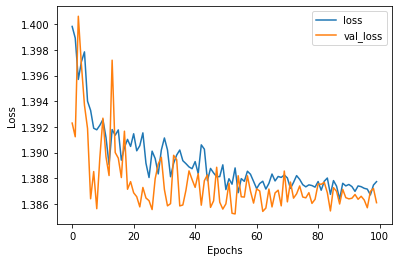

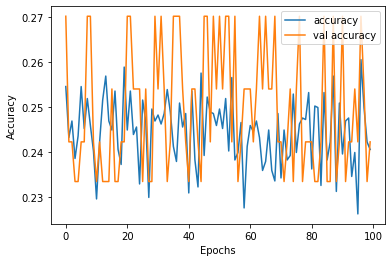

In [27]:
plot_learning_curve(history)

In [ ]:
def prediction(model,tokenizer,input_string):
    
    padded_tokens = tokenizer(
    text=[input_string],
    add_special_tokens=True,
    max_length=max_len,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = False,
    verbose = True)
    
    my_prediction = model.predict(padded_tokens['input_ids'])
    print(my_prediction)
    conversion_dict = {0:'joy',1:'fear',2:'anger',3:'sadness'}
    
    return conversion_dict[np.argmax(my_prediction)]

In [ ]:
# I am feeling scared
prediction(model,tokenizer,"मुझे डर लग रहा है")

In [ ]:
# I like bass
prediction(model,tokenizer,"J'aime la basse")

In [ ]:
#I am going to fail 我会失败
prediction(model,tokenizer,"我会失败")

In [ ]:
# My mother was killed
prediction(model,tokenizer,"मेरी मां को मार दिया गया")

In [ ]:
xtest_pad = tokenizer(
    text=test['Comment'].to_list(),
    add_special_tokens=True,
    max_length=max_len,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = False,
    verbose = True)
y


In [ ]:
model.evaluate(x=xtest_pad['input_ids'],y=ytest)

In [ ]:
xtest_pad['input_ids']